## Imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.figure import Figure
from scipy.signal import correlate
from scipy.stats import zscore
import numpy as np
import datetime as dt

from stock_modules.stock_transform import add_time_delta_column

# Read the data from the csv file
df = pd.read_csv('HEL_12-10-21to08-11-23.csv')
# Set date as date and add time delta col
df["date"] = pd.to_datetime(df["date"])
df = add_time_delta_column(df, date_col_name="date")

print(df.head())
print(df.describe())

                 date  Time Delta   REG1V.HE   NESTE.HE   ORNBV.HE   KNEBV.HE  \
0 2021-10-12 07:00:00           1  55.950001  41.820000  35.689999  60.220001   
1 2021-10-12 08:00:00           1  55.799999  41.720001  35.630001  60.419998   
2 2021-10-12 09:00:00           1  55.700001  42.060001  35.400002  60.200001   
3 2021-10-12 10:00:00           1  55.450001  42.009998  35.500000  60.119999   
4 2021-10-12 11:00:00           2  56.000000  42.000000  35.680000  60.480000   

    OLVAS.HE   HUH1V.HE   DETEC.HE   ORNAV.HE   CGCBV.HE   VAIAS.HE  \
0  53.099998  38.529999  23.000000  38.049999  43.139999  46.150002   
1  53.299999  38.560001  23.000000  38.049999  43.500000  45.950001   
2  53.200001  38.349998  23.000000  38.049999  43.619999  45.849998   
3  52.900002  38.220001  23.200001  38.049999  43.480000  45.700001   
4  52.599998  38.349998  23.200001  38.000000  43.279999  45.650002   

    ALBBV.HE   VALMT.HE   EQV1V.HE   PON1V.HE  
0  28.700001  36.459999  24.850000  39

## Exploratory Data Analysis

                      REG1V.HE   NESTE.HE   ORNBV.HE   KNEBV.HE   OLVAS.HE  \
date                                                                         
2021-10-12 07:00:00  55.950001  41.820000  35.689999  60.220001  53.099998   
2021-10-12 08:00:00  55.799999  41.720001  35.630001  60.419998  53.299999   
2021-10-12 09:00:00  55.700001  42.060001  35.400002  60.200001  53.200001   
2021-10-12 10:00:00  55.450001  42.009998  35.500000  60.119999  52.900002   
2021-10-12 11:00:00  56.000000  42.000000  35.680000  60.480000  52.599998   

                      HUH1V.HE   DETEC.HE   ORNAV.HE   CGCBV.HE   VAIAS.HE  \
date                                                                         
2021-10-12 07:00:00  38.529999  23.000000  38.049999  43.139999  46.150002   
2021-10-12 08:00:00  38.560001  23.000000  38.049999  43.500000  45.950001   
2021-10-12 09:00:00  38.349998  23.000000  38.049999  43.619999  45.849998   
2021-10-12 10:00:00  38.220001  23.200001  38.049999  43.480000

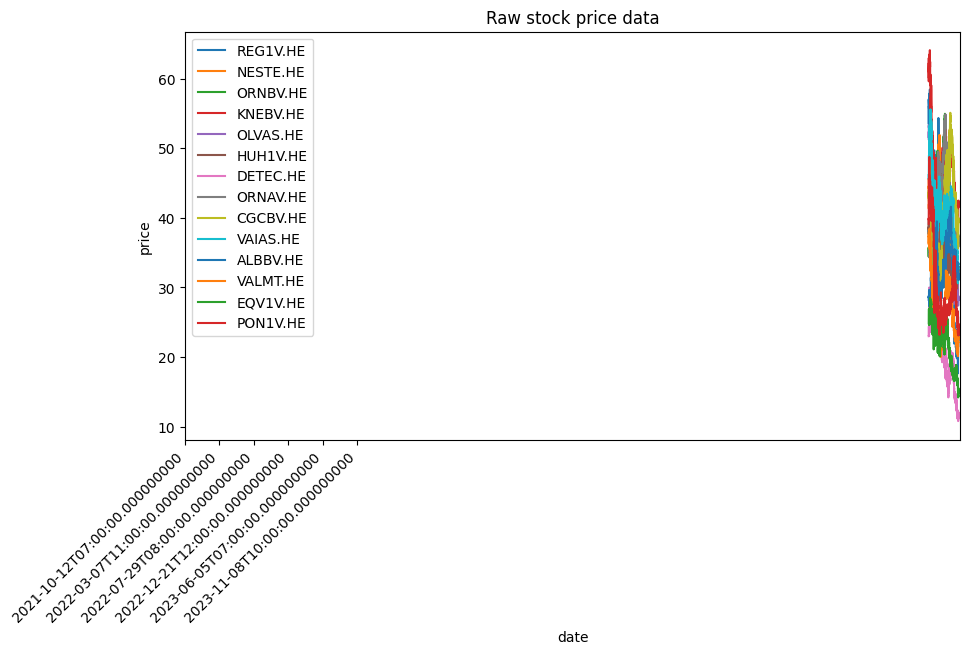

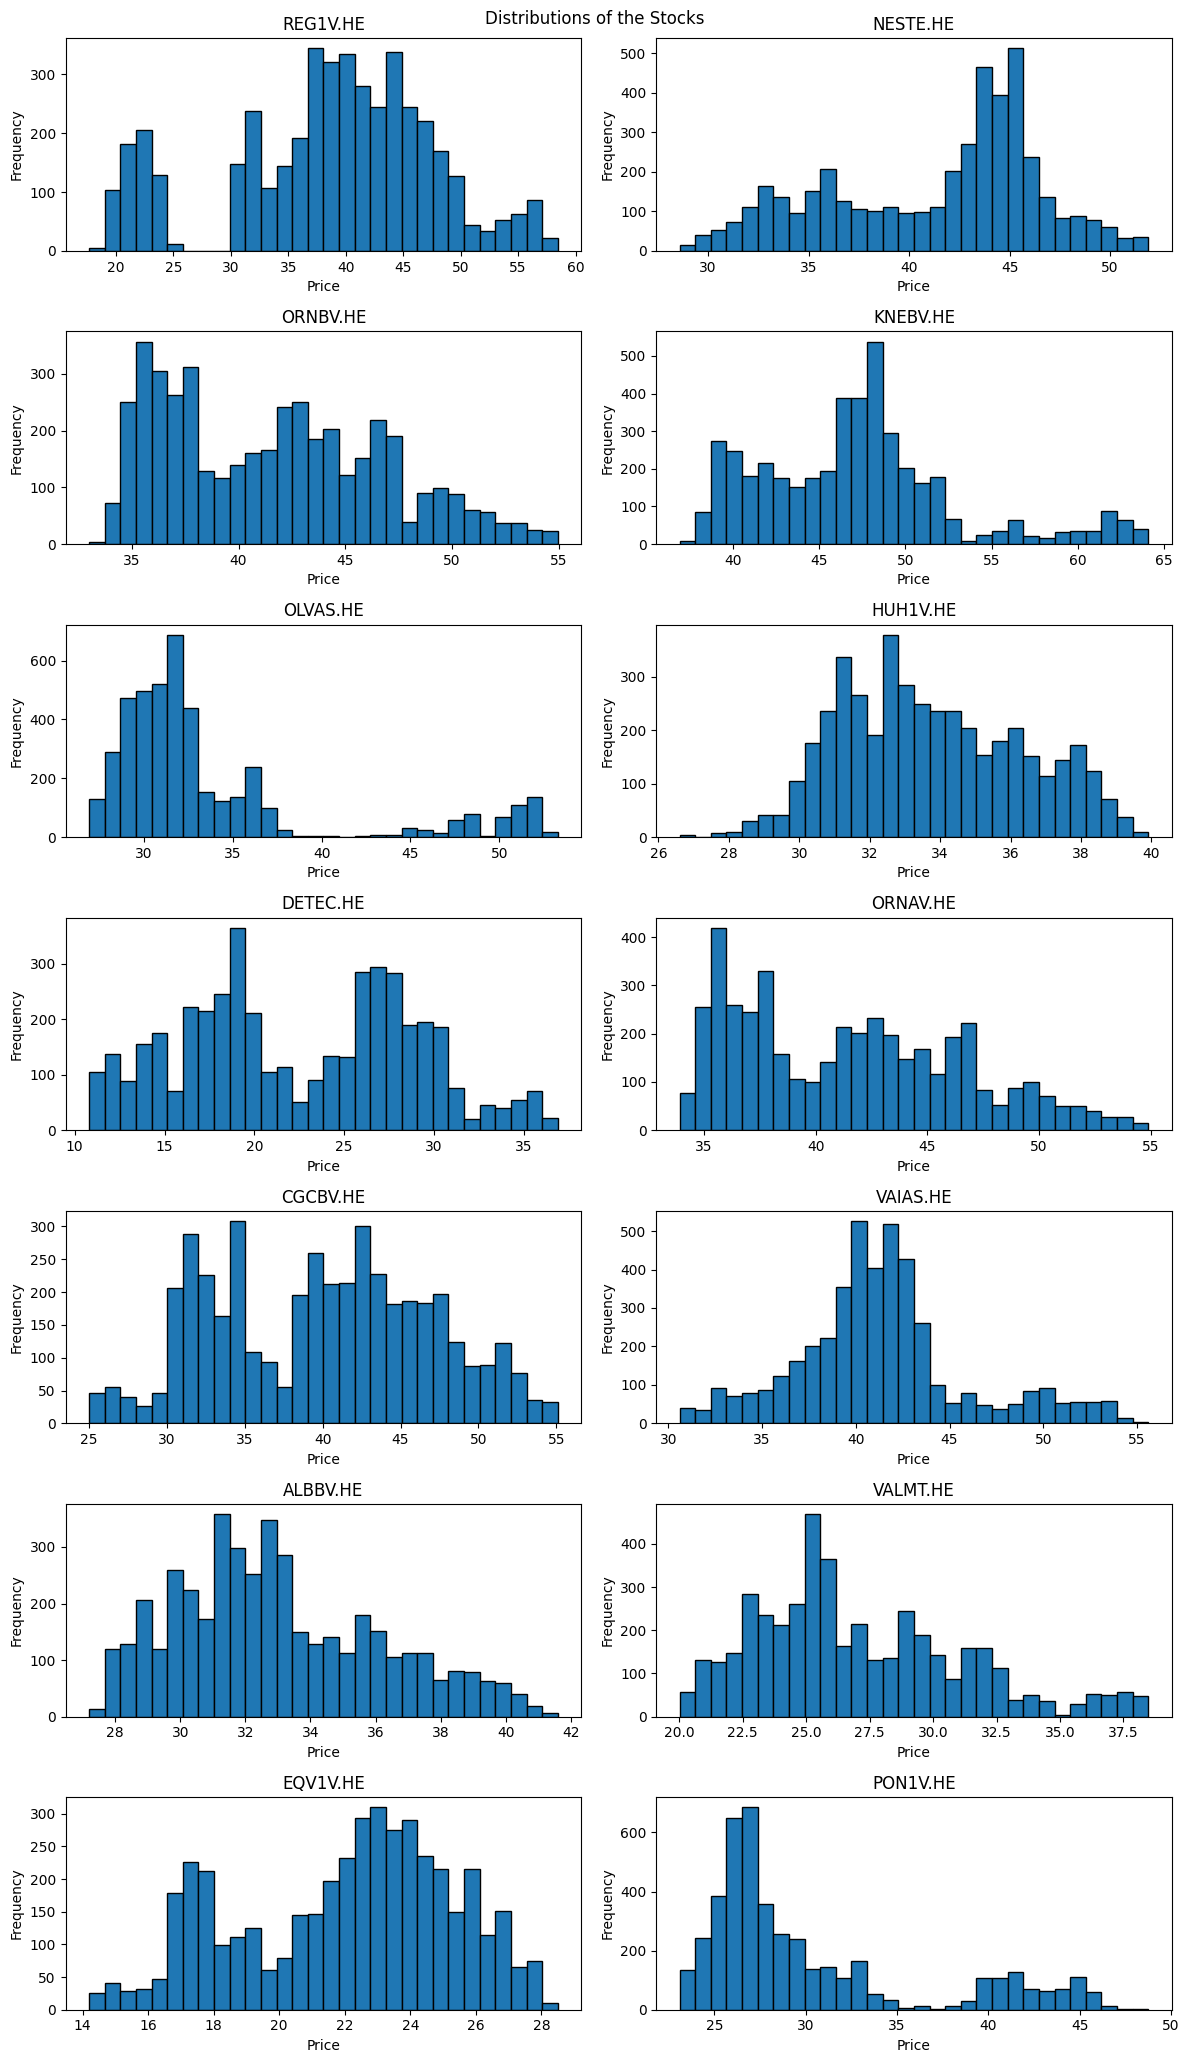

In [3]:
df_custom = df.drop(columns=["Time Delta"]).set_index("date")
print(df_custom.head())

fig, ax = plt.subplots(figsize=(10, 6))

df_custom.plot(ax=ax)

num_ticks = 5
xticks_idx = range(0, len(df_custom), len(df_custom)//num_ticks)
plt.xticks(xticks_idx, df_custom.index[xticks_idx].values, rotation=45)

plt.title('Raw stock price data')
plt.xlabel('date')
plt.ylabel('price')

fig.savefig("./figures/raw.svg")

num_columns = len(df_custom.columns)

# Calculate how many rows and columns for subplot
num_rows = (num_columns + 1) // 2  # Add 1 to round up for odd numbers
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 3 * num_rows))

for i, column in enumerate(df_custom.columns):
    row_index = i // num_cols
    col_index = i % num_cols
    ax = axes[row_index, col_index] if num_rows > 1 else axes[col_index]

    
    ax.hist(df_custom[column], bins=30, edgecolor='black')
    ax.set_title(f'{column}')
    ax.set_xlabel('Price')
    ax.set_ylabel('Frequency')

plt.suptitle('Distributions of the Stocks', )

plt.tight_layout()
plt.show()

fig.savefig("./figures/distributions.svg")

## Instant Cross-Correlation

## Time Auto-Correlation

In [4]:
df_custom = df.copy()
df_custom.set_index("date", inplace=True)

def find_ij_pairs(df : pd.DataFrame, td : int):
    """ Find the i-j pairs for a given time difference.
    - Find all pairs of indices (i,j), such that the total time difference sum(td(i:j)) is equal to the time difference.
    """
    i_j_pairs = []
    for i in range(len(df)):
        for j in range(i+1, len(df)-1):
            curr_sum = df["Time Delta"][i:j].sum()
            if curr_sum == td:
                i_j_pairs.append((i,j))
            if curr_sum >= td:
                break         
    return i_j_pairs

time_diffs = (1,8)
i_j_pairs_map = {}
for td in range(time_diffs[0], time_diffs[1]+1):
    i_j_pairs_map[td] = find_ij_pairs(df_custom, td)
    print(f"Time difference: {td} hours, number of pairs: {len(i_j_pairs_map[td])}")

Time difference: 1 hours, number of pairs: 3591
Time difference: 2 hours, number of pairs: 3128
Time difference: 3 hours, number of pairs: 2673
Time difference: 4 hours, number of pairs: 2249
Time difference: 5 hours, number of pairs: 1819
Time difference: 6 hours, number of pairs: 1406
Time difference: 7 hours, number of pairs: 963
Time difference: 8 hours, number of pairs: 506


Stock: REG1V.HE, Time Diff: 1, Correlation: 0.9991429744845121
Stock: REG1V.HE, Time Diff: 2, Correlation: 0.9983110163757288
Stock: REG1V.HE, Time Diff: 3, Correlation: 0.9975880391254283
Stock: REG1V.HE, Time Diff: 4, Correlation: 0.9969305066908613
Stock: REG1V.HE, Time Diff: 5, Correlation: 0.9962686851025886
Stock: REG1V.HE, Time Diff: 6, Correlation: 0.9956863025686928
Stock: REG1V.HE, Time Diff: 7, Correlation: 0.9950093091190939
Stock: REG1V.HE, Time Diff: 8, Correlation: 0.9943300264641428
Stock: NESTE.HE, Time Diff: 1, Correlation: 0.9978003522097102
Stock: NESTE.HE, Time Diff: 2, Correlation: 0.9959979615385544
Stock: NESTE.HE, Time Diff: 3, Correlation: 0.9937175788754127
Stock: NESTE.HE, Time Diff: 4, Correlation: 0.9916248356337442
Stock: NESTE.HE, Time Diff: 5, Correlation: 0.98979007506978
Stock: NESTE.HE, Time Diff: 6, Correlation: 0.988486932185716
Stock: NESTE.HE, Time Diff: 7, Correlation: 0.9864561845369827
Stock: NESTE.HE, Time Diff: 8, Correlation: 0.984274475326

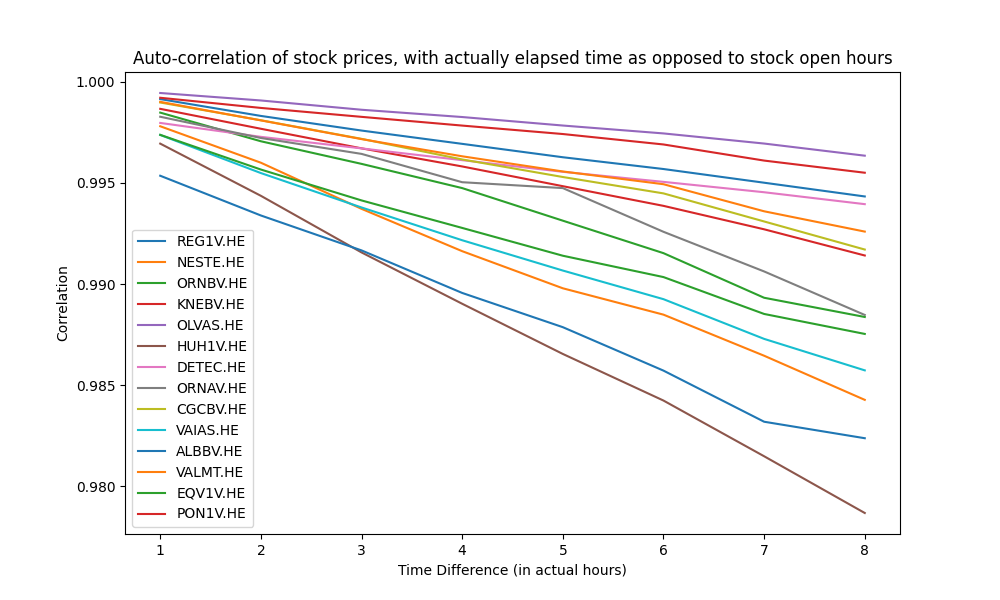

In [5]:
%matplotlib widget
stock_names = df_custom.columns[1:]
stock_auto_corrs = {}
for stock in stock_names:
    stock_auto_corrs[stock] = []
    for td in range(time_diffs[0], time_diffs[1]+1):
        # Calculate the pearson correlation between the stock price at i and j
        prices_at_i = np.array([df_custom[stock][i] for i,j in i_j_pairs_map[td]])
        prices_at_j = np.array([df_custom[stock][j] for i,j in i_j_pairs_map[td]])
        correlation = np.corrcoef(prices_at_i, prices_at_j)[0,1]
        if correlation == 0:
            stock_auto_corrs[stock].append(0)
            continue
        stock_auto_corrs[stock].append(correlation)
        print(f"Stock: {stock}, Time Diff: {td}, Correlation: {correlation}")

# Plot the auto-correlations
fig, ax = plt.subplots(figsize=(10, 6))
tds = list(range(time_diffs[0], time_diffs[1]+1))
for stock in stock_names:
    ax.plot(tds, stock_auto_corrs[stock], label=stock)
    
ax.set_xlabel("Time Difference (in actual hours)")
ax.set_ylabel("Correlation")
ax.set_title("Auto-correlation of stock prices, with actually elapsed time as opposed to stock open hours")

plt.legend()
plt.show()
                    


## Trend-Seasonality Decomposition

df_custom shape: (4389, 14)
df_custom shape: (18175, 14)
Period: 8, Entropy of residuals: 8.488120925980963
Period: 9, Entropy of residuals: 8.509993481311836
Period: 10, Entropy of residuals: 8.540712179230118
Period: 11, Entropy of residuals: 8.565545264350567
Period: 12, Entropy of residuals: 8.672916321823726
Period: 13, Entropy of residuals: 8.739801284279903
Period: 14, Entropy of residuals: 8.73967053287226
Period: 15, Entropy of residuals: 8.762100583982324
Period: 16, Entropy of residuals: 8.791373149186946


C:\Users\ilmari\AppData\Local\Temp\ipykernel_6316\765769313.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_custom = df_custom.append(pd.DataFrame(index=missing_indices, columns=df_custom.columns))


Period: 17, Entropy of residuals: 8.834130399234175
Period: 18, Entropy of residuals: 8.843752614656575
Period: 19, Entropy of residuals: 8.904955884290471
Period: 20, Entropy of residuals: 8.903791541694606
Period: 21, Entropy of residuals: 8.936337098094373
Period: 22, Entropy of residuals: 8.943118347321295
Period: 23, Entropy of residuals: 9.010733861588713
Period: 24, Entropy of residuals: 9.001592015702728
Period: 25, Entropy of residuals: 9.01425875273926
Period: 26, Entropy of residuals: 9.036747912652395
Period: 27, Entropy of residuals: 9.052180120955574
Period: 28, Entropy of residuals: 9.037014110228395
Period: 29, Entropy of residuals: 9.091146281926783
Period: 30, Entropy of residuals: 9.066914119253019
Period: 31, Entropy of residuals: 9.070255444282717
Period: 32, Entropy of residuals: 9.085636943425804
Period: 33, Entropy of residuals: 9.090329406614615
Period: 34, Entropy of residuals: 9.103997172476372
Period: 35, Entropy of residuals: 9.141439078279197
Period: 36, E

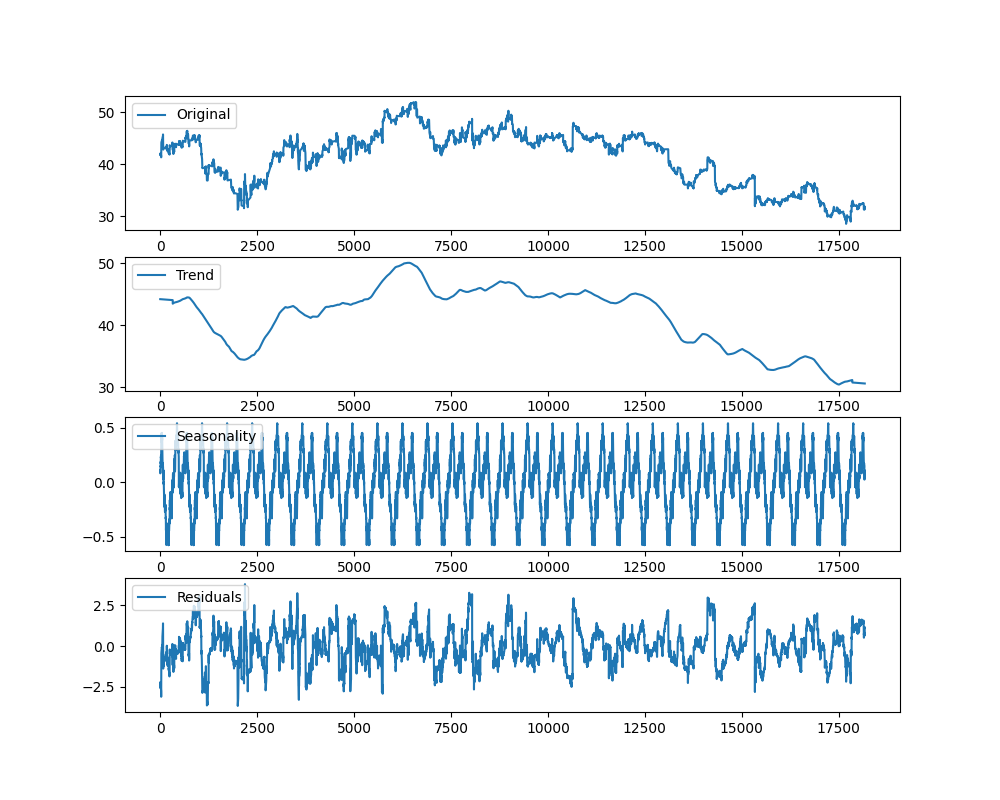

In [37]:
# Decompose PON1V.HE into trend, seasonal and residual components
from statsmodels.tsa.seasonal import seasonal_decompose
# Measure entropy of a series
from scipy.special import entr
def entropy(series):
    """ Calculate the entropy of a series. """
    series = series.values
    series = zscore(series)
    series = np.nan_to_num(series, nan=0)
    series = np.abs(series)
    series = series / series.sum()
    return entr(series).sum()

df_custom = df.copy()
df_custom["Total hours"] = np.cumsum(df_custom["Time Delta"])
df_custom.set_index("Total hours", inplace=True)
df_custom.drop(["date", "Time Delta"], axis=1, inplace=True)
print(f"df_custom shape: {df_custom.shape}")
# The spacing in the indices should be one, but it is not.
# We fix this by adding the missing indices, filling them with NaNs, and then interpolating.
curr_indices = df_custom.index.to_list()
full_indices = list(range(int(curr_indices[0]), int(curr_indices[-1])))
missing_indices = list(set(full_indices) - set(curr_indices))
# Add rows with nan values at each index of missing values
df_custom = df_custom.append(pd.DataFrame(index=missing_indices, columns=df_custom.columns))
# Sort the dataframe by index
df_custom.sort_index(inplace=True)
# Interpolate the missing values
df_custom.interpolate(method='linear', inplace=True)
print(f"df_custom shape: {df_custom.shape}")




stock_name = "NESTE.HE"
stock = df_custom[stock_name]

# Check different periods, and measure the entropy of the residuals
best_period = 8
most_entropy = 0
for period in range(8, 24*30, 1):
    result = seasonal_decompose(stock, model='additive', period=period, extrapolate_trend=1)
    entropy_resid = entropy(result.resid)
    print(f"Period: {period}, Entropy of residuals: {entropy_resid}")
    if entropy_resid < most_entropy:
        most_entropy = entropy_resid
        best_period = period
print(f"Best period: {best_period}, Entropy of residuals: {most_entropy}")

result = seasonal_decompose(stock, model='additive', period=best_period, extrapolate_trend="freq")

# Plot
fig, axes = plt.subplots(4, 1, figsize=(10, 8))
axes[0].plot(stock, label='Original')
axes[0].legend(loc='upper left')
axes[1].plot(result.trend, label='Trend')
axes[1].legend(loc='upper left')
axes[2].plot(result.seasonal, label='Seasonality')
axes[2].legend(loc='upper left')
axes[3].plot(result.resid, label='Residuals')
axes[3].legend(loc='upper left')
plt.show()





